In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import subprocess
import pickle
import subprocess
import spatter_util
import warnings
import importlib
importlib.reload(spatter_util)
warnings.filterwarnings('ignore')

# Getting Started with Spatter

Spatter is a memory benchmark suite designed to easily run a wide range of memory patterns on CPUs and GPUs. At the core of Spatter sit five kernels, Gather, Scatter, Concurrent Gather/Scatter a.k.a. GS, MultiGather, and MultiScatter. A detailed explanation of the Gather and Scatter kernels can be found in our MEMSYS'20 paper, which you can read [here](https://dl.acm.org/doi/abs/10.1145/3422575.3422794). The remaining 3 kernels are briefly described below:

Concurrent Gather/Scatter:
    `A[j[:]] = B[i[:]]`

MultiScatter:
    `A[j1[j2[:]]] = B[:]`

MultiGather:
    `A[:] = B[i1[i2[:]]]`

This notebook will guide you through building and running standard Spatter testsuites and will add the results to the plots found in our  Specifically, we will be adding your data to Figures 3, 5, and 9 from the paper.

To get started, fill out the information in the table below about your system. The data that comes pre-populated in this notebook was generated on an M1 Macbook Air.

In [2]:
platform_name  = 'M1'  # Used for plot legends
system_type    = 'cpu' # Change to 'gpu' if you have build a CUDA or OpenCL backend

## Building

We're going to build the OpenMP backend. You may use a different configure script if you like. If you change the configure script, change `build_dir` accordingly.

In [3]:
code_dir         = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
build_dir        = f'{code_dir}/build_openmp'
notebook_dir     = os.getcwd()
configure_script = 'cmake -DBACKEND=openmp -DCOMPILER=gnu -B build_openmp'
exe              = f'{build_dir}/spatter'

In [4]:
os.chdir(code_dir)
subprocess.run([f'{configure_script}'],shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)

os.chdir(build_dir)
subprocess.run(['make', '-j4'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)

os.chdir(notebook_dir)

## Understanding Spatter Output
First, let's look at how we can use Spatter to get a number similar to what John McCalpin's [STREAM](https://www.cs.virginia.edu/stream/) would give us. 

To accomplish this in Spatter, we want to create a pattern that will read in every element of an array with no reuse. This means we want an index buffer containing the numbers $0$ to $N-1$, and a `delta` of $N$. The value of $N$ does not change the data that is read, but may have performance implications for the architecture you're running on. A good value for CPUs is 8, and a good value for GPUs is 256. We want to run this test as a sanity check before running the more interested tests. 

One caveat when comparing to STREAM is that Spatter is designed to only produce Reads in Gather mode, and to only produce writes in Scatter mode. The numbers should still be similar, however. 

We'll write this one out by hand so we can look at some of the options Spatter supports. After this, we'll just run the scripts that run the standard testsuites. This test will require 1GiB of memory.

In [5]:
N      = 8                  # Index buffer length, as described above
index  = f'-pUNIFORM:{N}:1' # This is a shorthand that Spatter supports meaning "Uniform stride, length N, gap 1
                            # You could also write -p0,1,2,3,4,5,6,7
delta  = f'-d{N}'           # This is the delta applied to the base address between gathers/scatters
length = f'-l{2**24}'       # The -l (--length) option specifies how many gathers or scatters to perform
                            # With an index buffer of length 8, and 8 bytes per double, this will be 2^3 * 2^3 * 2^24 = 1GiB of data read

_ = subprocess.run([exe, index, delta, length], stdout=open('tmp.txt','w'))
with open('tmp.txt','r') as file:
    print(file.read())
os.remove('tmp.txt')


Running Spatter version 1.0
Compiler: GNU ver. 11.4.0
Compiler Location: /usr/bin/gcc
Backend: OPENMP
Aggregate Results? YES

Run Configurations
[ {'name':'UNIFORM:8:1', 'kernel':'Gather', 'pattern':[0,1,2,3,4,5,6,7], 'pattern_gather':[], 'pattern_scatter':[], 'delta':8, 'deltas_gather':[], 'deltas_scatter':[], 'length':16777216, 'agg':10, 'wrap':1, 'threads':6} ]

config  bytes        time(s)      bw(MB/s)    
0       1073741824   0.02392      44880.310834

Min         25%          Med          75%          Max         
44880.3      44880.3      44880.3      44880.3      44880.3     
H.Mean       H.StdErr    
44880.3      0           



### Spatter Output

There are 4 sections in the above output:
1. Build information
1. Run configuations

    - In this case there is only one. Spatter supports a JSON input to specify multiple run configuations. This saves time allocating memory as it can be re-used between benchmark runs. 
        
1. Time and effective bandwidth per configuration. 

    - In the run configuration, you'll see that "agg" is set to 10, meaning the configuation is an aggregate across 10 runs. We take the minimum time of all aggregated runs. 
    
1. Summary information

    - These numbers serve to summarize performance across all the the run configurations.

## Standard Suite 1: STREAM-like

Let's run the STREAM-like suite. This suite does runs each of the three kernels on patterns that read and write continuous buffers, much like STREAM. The difference is that the gather kernel only performs reads, and the the scatter kernel only performs writes. The GS kernel does both, and while this kernel does allow you you to specify different gather and scatter offsets, this test will set both to be `[0,1,2,3,4,5,6,7]`.

We won't make a plot from this data, but we'll use this to see how the other suites are run. This test will require 2GiB to run.

In [6]:
suite = f'../standard-suite/basic-tests/{system_type}-stream.json'
_ = subprocess.run([exe, f'-pFILE={suite}'], stdout=open(f'stream_custom{system_type}.txt','w'))

In [7]:
stream_df = spatter_util.file2df(f'stream_custom{system_type}.txt')

print(f'Gather       Bandwidth: {stream_df["bw(MB/s)"][1]} MB/s') # The second pattern is a gather kernel
print(f'Scatter      Bandwidth: {stream_df["bw(MB/s)"][0]} MB/s') # The first pattern is a scatter kernel
print(f'GS           Bandwidth: {stream_df["bw(MB/s)"][2]} MB/s') # The third pattern is a gather/scatter kernel
print(f'MultiGather  Bandwidth: {stream_df["bw(MB/s)"][4]} MB/s') # The fifth pattern is a multigather kernel
print(f'MultiScatter Bandwidth: {stream_df["bw(MB/s)"][3]} MB/s') # The fourth pattern is a multiscatter kernel

Gather       Bandwidth: 26208.701399 MB/s
Scatter      Bandwidth: 44916.195634 MB/s
GS           Bandwidth: 73718.785152 MB/s
MultiGather  Bandwidth: 38460.093897 MB/s
MultiScatter Bandwidth: 36348.308375 MB/s


## Standard Suite 2: Uniform Stride

This suite runs gather and scatter patterns at power of 2 strides, from 1 to 128. Because we are access doubles, a stride of 8 means we are accessing 1 element from every 64-byte cache line. We expect to see effective bandwidth roughly level out at this point, although this is not the case on all systems! You can check out the paper for more on this plot!

This test will require 2GB of memory. The plots in the paper used 16 GB but we want this notebook to run quickly on laptops with less memory. The paper did not do experiments with the GS kernel, so we will not be using that kernel here.

In [8]:
# Run the suite

suite = f'../standard-suite/basic-tests/{system_type}-ustride.json'
subprocess.run([exe, f'-pFILE={suite}'], stdout=open(f'ustride_custom{system_type}.txt','w'))
ustride_df = spatter_util.file2df(f'ustride_custom{system_type}.txt')
ustride_df = ustride_df.rename(columns={'bw(MB/s)':'bw'})

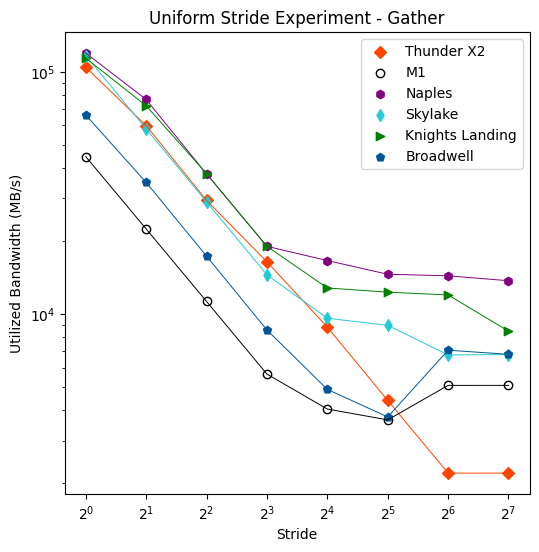

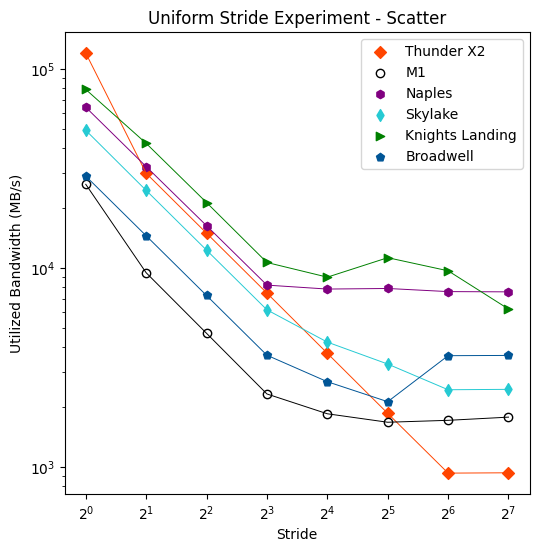

In [9]:
spatter_util.ALLNAMES['customcpu'] = platform_name 

spatter_util.ustride_plot(ustride_df, 'Gather')
spatter_util.ustride_plot(ustride_df, 'Scatter')

Your data should appear as white circles with a black outline. This corresponds to Figure 3 in the paper. If you build for GPU, and set the Configuration Information above appropriately, you can use this same process to recreate Figure 5.

## Standard Suite 3: Application Patterns

The plots for app patterns are much more complicated, but their strucure allows us to compare systems both in terms of the absolute bandwdith they utilize for each pattern (by looking at the y-value of the points) as well as the percent of the available bandwidth they utilize (by looking at the distance of each point from the y=x line, which represents STREAM or Stride-1 bandwidth. 

The plots in the paper contain patterns from PENNANT and LULESH. We'll run those two, but you can also run the Nekbone and AMG patterns if you like.

The PENNANT patterns may take a couple minutes to run.

In [10]:
if (system_type == 'cpu'):
    lulesh_suite  = '../standard-suite/app-traces/lulesh.json'
    pennant_suite = '../standard-suite/app-traces/pennant.json'
else: 
    lulesh_suite  = '../standard-suite/app-traces/lulesh_gpu.json'
    pennant_suite = '../standard-suite/app-traces/pennant_gpu.json'

_=subprocess.run([exe, f'-pFILE={lulesh_suite}'], stdout=open(f'lulesh_custom{system_type}.txt','w'))
_=subprocess.run([exe, f'-pFILE={pennant_suite}'], stdout=open(f'pennant_custom{system_type}.txt','w'))

In [11]:
df_lulesh  = spatter_util.file2df(f'lulesh_custom{system_type}.txt')
df_pennant = spatter_util.file2df(f'pennant_custom{system_type}.txt')

notebook_df    = pd.concat([df_lulesh, df_pennant], ignore_index=True)
ustride_df     = spatter_util.file2df(f'ustride_custom{system_type}.txt') # Read this in again without re-naming
notebook_df    = pd.concat([ustride_df, notebook_df], ignore_index=True) # Join data from ustride above, we need this for the y=x line on the plot
notebook_system_type = system_type # Used by the plotting script

# Optional - Remove systems from the plot that overlap with your system. The full list is ['bdw', 'npl', 'tx2', 'skx', 'clx', 'titan', 'p100', 'gv100']
notebook_remove = ['bdw', 'npl', 'tx2', 'skx']

# The plotting script also imports spatter_util so we can change values here
spatter_util.ALLNAMES['customcpu'] = platform_name 

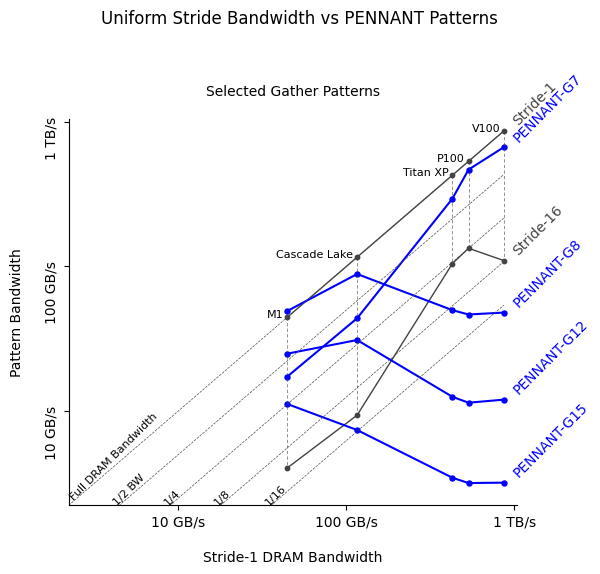

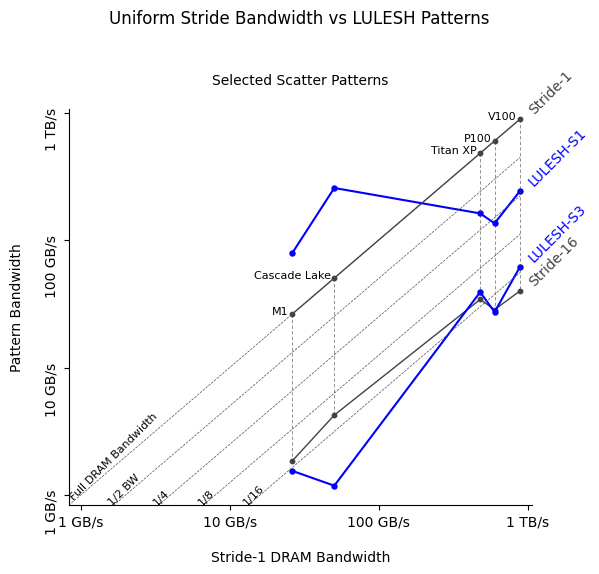

In [12]:
# We'll just call a scrip to make this one -- it's too complicated to include here
# These plots may not render properly on python < 3.8
%run -i 'bwbw_plot.py' 'Gather'
%run -i 'bwbw_plot.py' 'Scatter'

# Next Steps

- Dig into other Spatter options in the [README.md](https://github.com/hpcgarage/spatter#readme)

- Capture app patterns for your app with our [DyanamoRIO tracing tool](https://github.com/hpcgarage/dr-gather-scatter-trace). (Note: This tool isn't quite ready to generate JSON input for Spatter. Let us know if you're intested in using it!)

- See more experiments in our [paper](https://dl.acm.org/doi/abs/10.1145/3422575.3422794)

## Issues and Improvements

Have issues running this notebook? Have ideas for improving or extending Spatter? Submit an issue [here](https://github.com/hpcgarage/spatter/issues), or submit a PR!

